# Create clean array from file

In [23]:
%matplotlib inline
import numpy as np
import pylab as p

MJtoMsun = 0.000954265748
RJtoAU = 0.000477894503

def has_numbers(inputString):
    '''Checks if inputString contains any numerical value'''
    return any(char.isdigit() for char in inputString)

def convert(inputList):
    '''Attempts to convert elements of list to floats. If not, keep as string.'''
    outputList = []
    for x in inputList:
        try:
            x = float(x)
        except ValueError:
            x = np.nan
        outputList.append(x)
    return outputList

def clean_array(array):
    '''Cleans the array from a file generated from exoplanets.org into a more readable format'''
    tmp = [ i for i in array if has_numbers(i) ]
    tmp = np.transpose( [ [x for x in i.split(',')] for i in tmp] )
    return [ np.array(convert(x)) for x in tmp ]

def create_array_from_file(file):
    '''Creates a cleaned array from input file'''
    with open(file) as f:
        array = f.read().splitlines()    
    return clean_array(array)

file = 'planets_2005.in'
data = create_array_from_file(file)
print("Number of planets:", len(data[0]))

Number of planets: 23


In [24]:
data[25] = np.array([ 1.2 for i in range(len(data[25])) ])

keys = [ "names",
        "Mpl", "Mpl_upper", "Mpl_lower", "Mpl_sigma",\
        "Mstar", "Mstar_upper", "Mstar_lower", "Mstar_sigma", \
        "sma", "sma_upper", "sma_lower", "sma_sigma", \
        "per", "per_upper", "per_lower", "per_sigma", \
        "ecc", "ecc_upper", "ecc_lower", "ecc_sigma", \
        "amp", "amp_upper", "amp_lower", "amp_sigma", \
        "rad", "rad_upper", "rad_lower", "rad_sigma" ]
data_dict = dict(zip(keys, data))

a_roche = data_dict["rad"] * RJtoAU / ( 0.462 * (data_dict["Mpl"] * MJtoMsun / data_dict["Mstar"])**0.3333 )
xlist = data_dict["sma"] / a_roche
xlist = xlist[~np.isnan(xlist)]
print("Number of planets:", len(xlist))
print(xlist)

Number of planets: 23
[  1.98121039   8.96181964   2.34745718   2.2335696   11.24154155
   2.76823131   3.13827158   2.36412532   9.08216907   2.69539832
   2.25298838   2.76781018   3.17594377   2.99309386   7.65281113
   3.18510834   6.42980296   2.76046825   3.57026218  16.4517982
  15.52076534   5.54055343  16.02714509]


# Define likelihood, prior, posterior

In [25]:
def lnlike(theta):
    '''Function to compute truncated power law likelihood. Theta is a tuple consisting of gamma, xlower, xupper.'''
    gamma, xl, xu = theta
    assert xl < xu
    n = len(xlist)
    return n * (np.log(gamma / (xu**gamma - xl**gamma))) \
            + sum([ (gamma-1.)*np.log(x) if xl < x < xu else -np.inf for x in xlist ])


def lnprior(theta):
    gamma, xl, xu = theta
    if -5. < gamma < 5. and 0. < xl < 5. and 15. < xu < 100.:
        return 0.
    return -np.inf
    

def lnpost(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

# Do MCMC

In [26]:
import emcee

In [27]:
ndim, nwalkers = 3, 20
pos = [(0., 0.9*min(xlist), 1.1*max(xlist)) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)
sampler.run_mcmc(pos, 5000);

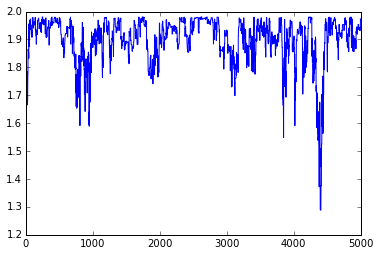

In [28]:
samples = sampler.chain[:, 500:, :].reshape(-1,ndim)
p.plot(sampler.chain[0, :, 1])
p.show()

# Plot everything vs. everything

//anaconda/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


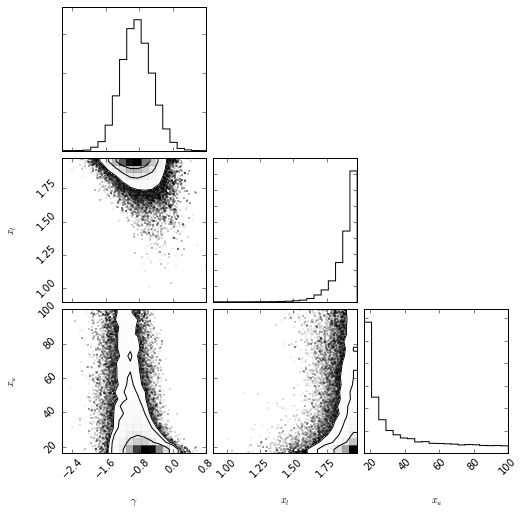

In [29]:
import corner
fig = corner.corner(samples, labels=["$\gamma$", "$x_l$", "$x_u$"])
fig.show()

# Now using the updated list of planets...

In [8]:
file = 'planets_2015.in'
data = create_array_from_file(file)
data[25] = np.array([ 1.2 for i in range(len(data[25])) ])
data_dict = dict(zip(keys, data))

a_roche = data_dict["rad"] * RJtoAU / ( 0.462 * (data_dict["Mpl"] * MJtoMsun / data_dict["Mstar"])**0.3333 )
xlist = data_dict["sma"] / a_roche
xlist = xlist[~np.isnan(xlist)]
print("Number of planets:", len(xlist))
print(xlist)

Number of planets: 39
[  1.98121039   8.96181964   3.62857738   2.34745718   3.97442059
  12.4116158    2.2335696   11.24154155   3.39061648   2.76823131
   3.13827158   2.36412532   3.40934706   9.08216907   1.95575668
   2.69539832   3.06151417   2.25298838   2.76781018   5.31690031
   3.17594377   5.50800406   2.99309386   7.65281113   3.18510834
   5.03121024   4.67332499   4.35338644   6.42980296   2.76046825
   2.94760635   6.70366439   3.57026218  16.4517982   17.7297777
   3.16857837  15.52076534   5.54055343  16.02714509]


In [9]:
pos = [(0., 0.9*min(xlist), 1.1*max(xlist)) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)
sampler.run_mcmc(pos, 5000);

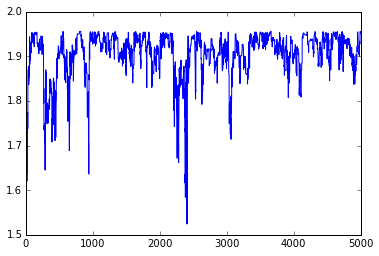

In [10]:
samples = sampler.chain[:, 500:, :].reshape(-1,ndim)
p.plot(sampler.chain[0, :, 1])
p.show()

//anaconda/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


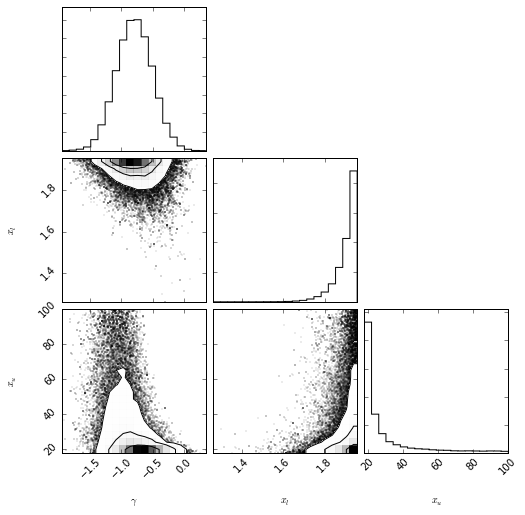

In [11]:
fig = corner.corner(samples, labels=["$\gamma$", "$x_l$", "$x_u$"])
fig.show()

# Now for the transiting sample with measured Ks...

In [12]:
file = 'planets_2015_transit.in'
data = create_array_from_file(file)
keys = [ "names",
        "Mpl", "Mpl_upper", "Mpl_lower", "Mpl_sigma",\
        "Mstar", "Mstar_upper", "Mstar_lower", "Mstar_sigma", \
        "sma", "sma_upper", "sma_lower", "sma_sigma", \
        "per", "per_upper", "per_lower", "per_sigma", \
        "ecc", "ecc_upper", "ecc_lower", "ecc_sigma", \
        "amp", "amp_upper", "amp_lower", "amp_sigma", \
        "rad", "rad_upper", "rad_lower", "rad_sigma", \
        "obl", "obl_upper", "obl_lower", "obl_sigma"]
data_dict = dict(zip(keys, data))

a_roche = data_dict["rad"] * RJtoAU / ( 0.462 * (data_dict["Mpl"] * MJtoMsun / data_dict["Mstar"])**0.3333 )
xlist = data_dict["sma"] / a_roche
xlist = xlist[~np.isnan(xlist)]
print("Number of planets:", len(xlist))
print(xlist)

Number of planets: 207
[  2.48723829   3.47897976   2.91617723   4.04851421   3.65143542
   2.51785163   3.09414984   2.45291916   2.76943653   2.52103156
   4.84826412   2.7562826    4.65898349   2.75449684   2.02502984
   2.76873913   2.24407864   2.60338904   3.1138418    2.63057627
   2.44812043   2.74983918   2.75881982   4.60284521   2.38737631
   3.01392714   4.65440338   2.48745376   2.14458877   7.08660228
   2.63043601   1.85235745   3.42970175   2.97603388   3.29481749
   4.58669393   3.95849645   2.75930415   6.15601402   2.84433874
   2.65941124   2.32333597   3.72980087   4.0496997    3.44572179
   2.53920214   4.00229802   3.22521157   3.17915126   3.38015785
   3.21841159   2.30957853   2.74906386   3.07359289   3.07942915
   7.30874782   3.66592681   4.95382474   4.90849537   2.71299896
   2.69352318   2.69768407   2.97040793   4.00482193   2.96521842
   2.31620682   1.63953493   2.89236824   3.0413722    2.97782486
   2.64374856   2.46693102   2.50022779   3.54532141 

In [13]:
pos = [(0., 0.9*min(xlist), 1.1*max(xlist)) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)
sampler.run_mcmc(pos, 5000);

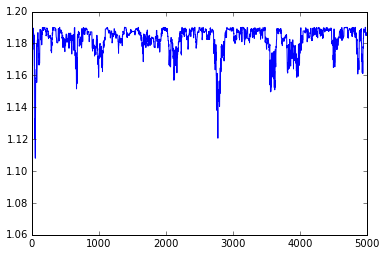

In [19]:
samples = sampler.chain[:, 500:, :].reshape(-1,ndim)
p.plot(sampler.chain[0, :, 1])
p.show()

//anaconda/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


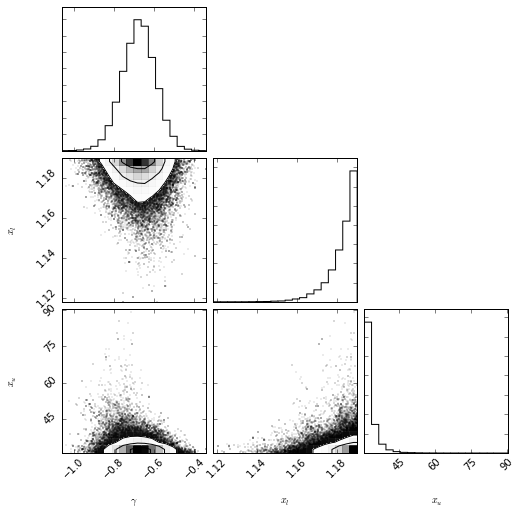

In [15]:
fig = corner.corner(samples, labels=["$\gamma$", "$x_l$", "$x_u$"])
fig.show()

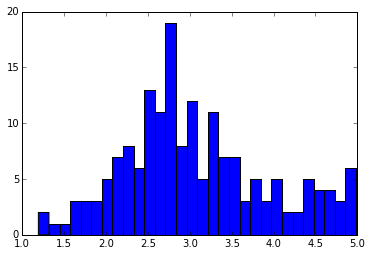

In [20]:
p.hist([ x for x in xlist if x < 5.], bins=30)
p.show()

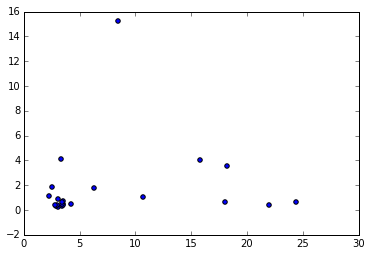

In [30]:
p.scatter(data_dict["per"], data_dict["Mpl"])
p.show()

# Are there any trends in x vs. obliquity?

ValueError: In safezip, len(args[0])=60 but len(args[1])=59

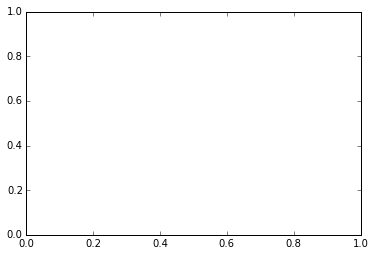

In [17]:
obl = data_dict["obl"]
obl = obl[~np.isnan(obl)]

obl_sigma = data_dict["obl_sigma"]
obl_sigma = obl_sigma[~np.isnan(obl_sigma)]

p.errorbar(xlist, obl, yerr=obl_sigma, linestyle="None")
p.xlabel("x [a/a_R]")
p.ylabel("Obliquity [degrees]")
p.show()

In [ ]:
names = data[0]

Mpl = data[1] * MJtoMsun
Mpl_upper = data[2] * MJtoMsun
Mpl_lower = data[3] * MJtoMsun
Mpl_sigma = data[4] * MJtoMsun

Mstar = data[5]
Mstar_upper = data[6]
Mstar_lower = data[7]
Mstar_sigma = data[8]

sma = data[9]
sma_upper = data[10]
sma_lower = data[11]
sma_sigma = data[12]

per = data[13]
per_upper = data[14]
per_lower = data[15]
per_sigma = data[16]

ecc = data[17]
ecc_upper = data[18]
ecc_lower = data[19]
ecc_sigma = data[20]

amp = data[21]
amp_upper = data[22]
amp_lower = data[23]
amp_sigma = data[24]

rad = np.array([ 1.2 for i in range(len(data[25])) ]) * RJtoAU

if file == 'planets_2015_transit.in':
    rad = data[25] * RJtoAU

rad_upper = data[26] * RJtoAU
rad_lower = data[27] * RJtoAU
rad_sigma = data[28] * RJtoAU

if file == 'planets_2015_transit.in':
    obl = data[29]
    obl_upper = data[30]
    obl_lower = data[31]
    obl_sigma = data[32]

a_roche = rad / ( 0.462 * (Mpl/Mstar)**0.3333 )
xlist = sma / a_roche
xlist = xlist[~np.isnan(xlist)]

#p.errorbar(xlist, obl, yerr=obl_sigma, linestyle="None")
#p.xlim(0.,3.)
#p.xlabel("x [a/a_R]")
#p.ylabel("Obliquity [degrees]")
#p.savefig("x_vs_obliquity_zoom.png")

if file == 'planets_2015_transit.in':
    p.hist([x for x in xlist if x<4.], bins=20)
    p.xlabel("x [a/a_R]")
    p.show()